In [1]:
# the class to hande histograms and some helper functions
import copy
import math
import os

def safediv(a,b):
    if float(b) != 0.:
        return a/b
    else:
        return 0.

def get_histo_from_file(fname, hname, htype, nrebin=1, fixrate=False, totrate=0.):
    content = open(fname).read()
    found = False
    xmin = []
    xmax = []
    y = []
    yerr = []
    
    for l in content.split('\n'):

        if l.startswith("<histogram>") and l.split('"')[1].strip().startswith(hname) and \
        ('TYPE@%s|' % htype in l or 'TYPE@%s"' % htype in l or '|T@%s ' % htype in l):
            found = True
            continue
        if found and l.startswith("<\\histogram>"):
            break
        if found:
            values = [float(v) for v in l.split()]
            xmin.append(values[0])
            xmax.append(values[1])
            y.append(values[2])
            yerr.append(values[3])
    if not found:
        print('Not found, ', fname, hname, htype)
        raise HistoNotFound('get_histo_from_file, not found', fname, hname, htype)
    return Histogram(xmin, xmax, y, yerr, fixrate, totrate).rebin(nrebin)


def get_histo_from_datfile(fname, nevents=1., nrebin=1):
    content = open(fname).read()
    xmin = []
    xmax = []
    y = []
    yerr = []
    
    for l in content.split('\n'):
        if not(l): continue
        if l.startswith('#') or l.strip().startswith('No'): continue
        values = [float(v) for v in l.split()]
        xmin.append(values[0])
        xmax.append(values[1])
        y.append(values[2]/nevents)
        if values[3] != 0:
            yerr.append(values[2]/math.sqrt(values[3])/nevents)
        else:
            yerr.append(0)

    return Histogram(xmin, xmax, y, yerr).rebin(nrebin)
            
class HistoNotFound(Exception):
    pass

class Histogram(dict):
    def __init__(self, xmin, xmax, y, yerr, fixrate=False, rate=0.):
        if not (len(xmin)==len(xmax)==len(y)==len(yerr)):
            raise Exception('Init, Invalid size')
                
        self['xmin'] = xmin
        self['xmax'] = xmax
        self['x'] = [(x1+x2)/2 for x1,x2 in zip(xmin,xmax)]
        self['xlo'] = xmin
        self['xhi'] = xmax
        self['y'] = y
        self['yerr'] = yerr
        self['nbins'] = len(xmin)
        
        if fixrate:
            # this is for mtt, with issues related to overflow in the last bin
            # change the rate of the last bin so that the total rate of
            # the histogram is equal to rate
            self['y'][-1] += rate - self.totrate
                
    
    def __add__(self, other):
        if type(other) == Histogram:
            if not (len(self['y']) == len(other['y'])):
                raise Exception('add, Invalid size')
            if not (self['xmin'] == other['xmin'] and self['xmax'] == other['xmax']):
                raise Exception('add, Invalid x')
            return Histogram(self['xmin'], self['xmax'],
                        [y1+y2 for y1,y2 in zip(self['y'], other['y'])],
                        [math.sqrt(y1**2+y2**2) for y1,y2 in zip(self['yerr'], other['yerr'])])
        elif type(other) in [int, float]:
            return Histogram(self['xmin'], self['xmax'],
                        [y1+other for y1 in self['y']],
                        self['yerr'])
        else:
            raise(Exception, 'invalid type %s' % type(other))
            
    
    def __sub__(self, other):
        return self + (other * (-1))
    
    
    
    def __mul__(self, other):
        if type(other) == float or type(other) == int:
            return Histogram(self['xmin'], self['xmax'],
                    [y1*other for y1 in self['y']],
                        [y1*other for y1 in self['yerr']])
        else:
            raise Exception('mul, not implemented')
            
            
    def __truediv__(self, other):
        if type(other) == float or type(other) == int:
            return Histogram(self['xmin'], self['xmax'],
                    [y1/other for y1 in self['y']],
                        [y1/other for y1 in self['yerr']])
        elif type(other) == Histogram:
            if not (len(self['y']) == len(other['y'])):
                raise Exception('div, Invalid size')
            if not (self['xmin'] == other['xmin'] and self['xmax'] == other['xmax']):
                raise Exception('div, Invalid x', self['xmin'], other['xmin'], self['xmax'], other['xmax'])
            return Histogram(self['xmin'], self['xmax'],
                        [safediv(y1,y2) for y1,y2 in zip(self['y'], other['y'])],
                        [math.sqrt(safediv(e1,y2)**2+(safediv(y1,y2**2)*e2)**2) for y1,y2,e1,e2 in zip(self['y'], other['y'], self['yerr'], other['yerr'])])
            
        else:
            raise Exception('div, not implemented')
            
    
    def rebin(self, nbins):
        if (self['nbins']//nbins)*nbins != self['nbins']:
            print('cannot rebin')
            return self
        if nbins == 1:
            return self
        xmin = []
        xmax = []
        y = []
        yerr = []
        for i in range(self['nbins']//nbins):
            i0 = i * nbins
            i1 = (i+1) * nbins  - 1
            xmin.append(self['xmin'][i0])
            xmax.append(self['xmax'][i1])
            y.append(sum(self['y'][i0:i1+1]))
            yerr.append(math.sqrt(sum([err**2 for err in self['yerr'][i0:i1+1]])))
        
        return Histogram(xmin,xmax,y,yerr)
    
    def replacefirstbins(self, other, xx):
        ### replace the first bins of self (with x < xx) with those of others
        if not (self['xmin'] == other['xmin'] and self['xmax'] == other['xmax']):
            raise Exception('Invalid x', self['xmin'], other['xmin'], self['xmax'], other['xmax'])
        
        #find the first x > xx
        for i, x in enumerate(self['x']):
            if x > xx:
                break
        self['y'] = other['y'][:i] + self['y'][i:]
        self['yerr'] = other['yerr'][:i] + self['yerr'][i:]
        
    
        
    
    def maxv_n(self, i):
        """return the next^i to maximum"""
        values = sorted(self['y'], reverse=True)
        return values[i]
    
    @property
    def maxv(self):
        return max(self['y'])
    
    
    @property
    def totrate(self):
        return sum(self['y'])
        
    @property
    def minv(self):
        return min([v for v in self['y'] if v != 0])


In [2]:
# matplotlib setup and some definitions
import os
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.lines as mlines
lw = 1.2
allcolors = list(mcolors.TABLEAU_COLORS.values()) + list(mcolors.BASE_COLORS.values()) + list(mcolors.XKCD_COLORS.values())
allcolors[1] = 'black'
allcolors[0] = 'blue'
allcolors[3] = 'red'
import matplotlib.font_manager as font_manager
import matplotlib.backends.backend_pdf as backend_pdf
from matplotlib.ticker import MultipleLocator,AutoMinorLocator

import matplotlib as mpl
#mpl.rcParams.update({"mathtext.fontset": "dejavuserif"})
mpl.rcParams.update({"text.usetex": True, "font.family": "serif", "font.size": 14})
mpl.rcParams.update({'lines.markersize': 8})
#mpl.rcParams.update({'lines.linewidth': 0.5})
markers_glob = ['o', 'v', 's', '<', '>', 's', 'p', '*', 'h', 'p', 'x', 'X', 'd']
font_legend = font_manager.FontProperties(size=10)

def update_legend(ax, ncol):
    # this is to have the line in the legend, and not the square
    handles, labels = ax.get_legend_handles_labels()
    new_handles = []
    for i, h in enumerate(handles):
        ls = h.get_linestyle()
        lc = h.get_edgecolor()
        #mk = markers[i]
        if ls == 'dashed':
            facecolor = 'none'
        else:
            facecolor = lc
        #new_handles.append(mlines.Line2D([], [], c=lc, linestyle=ls, marker = mk, markerfacecolor = facecolor))
        new_handles.append(mlines.Line2D([], [], c=lc, linestyle=ls, markerfacecolor = facecolor))

    ax.legend(handles=new_handles, labels=labels, prop=font_legend, frameon = False, ncol=ncol,
              loc='upper left', bbox_to_anchor=(1, 1.1))


xlabels = {'tt': {'mtt': 'm(t\\bar t)',
                  'pttt': 'p_T(t\\bar t)',
                  'pttop': 'p_T(t)',
                  'thetatt': '\\theta(t\\bar t)',
                  'top rap': 'y(t)',
                  'tt rap': 'y(t\\bar t)'},
           'ww': {'mtt': 'm(W^+W^-)',
                  'pttt': 'p_T(W^+W^-)',
                  'pttop': 'p_T(W^+)',
                  'thetatt': '\\theta(W^+W^-)',
                  'top rap': 'y(W^+)',
                  'tt rap': 'y(W^+W^-)'}}
proc_string = {'tt': '$\\mu^+\\mu^- \\to t \\bar t$',
               'ww': '$\\mu^+\\mu^- \\to W^+ W^-$'}





0.00028875220796999987 -4
0.0044544353041 -3
0.014272210592380012 -2
0.25234103157779963 -1
2.503255322138912 0
[(450.0, -0.3, 5.896366580058481)] [(750.0, -0.3, 2.503255322138912), (1350.0, -0.3, 0.25234103157779963), (2250.0, -0.3, 0.014272210592380012), (2550.0, -0.3, 0.0044544353041), (2850.0, -0.3, 0.00028875220796999987)]
4.99368439 0
0.7152170199999999 -1
1.3172682199999999 0
[(2850.0, -0.3, 15.23267201), (450.0, -0.3, 4.99368439), (1350.0, -0.3, 0.7152170199999999), (2550.0, -0.3, 1.3172682199999999)] []
0.00024177107675799953 -4
0.0010757668693119984 -3
0.01914963312832998 -2
0.1574297673241399 -1
4.0934254098575895 0
[(500.0, -0.3, 24.087332346086953)] [(1500.0, -0.3, 4.0934254098575895), (3500.0, -0.3, 0.1574297673241399), (5500.0, -0.3, 0.01914963312832998), (8500.0, -0.3, 0.0010757668693119984), (9500.0, -0.3, 0.00024177107675799953)]
1.472696407 0
0.135033046 -1
0.08406630699999999 -2
0.16792903199999998 -1
2.80001245 0
[(500.0, -0.3, 17.397234299999997)] [(1500.0, -0.3, 

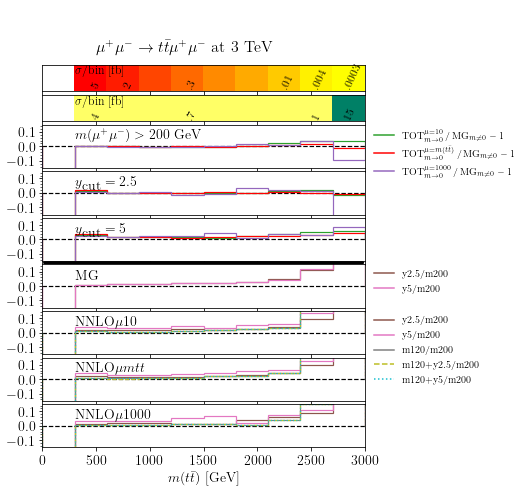

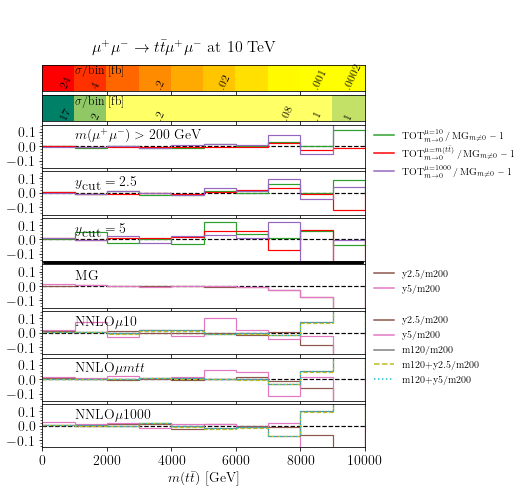

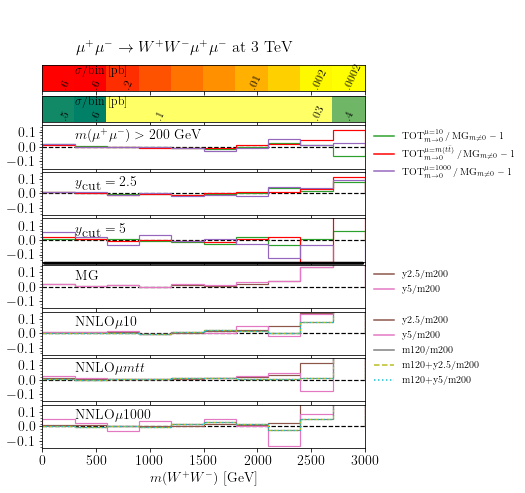

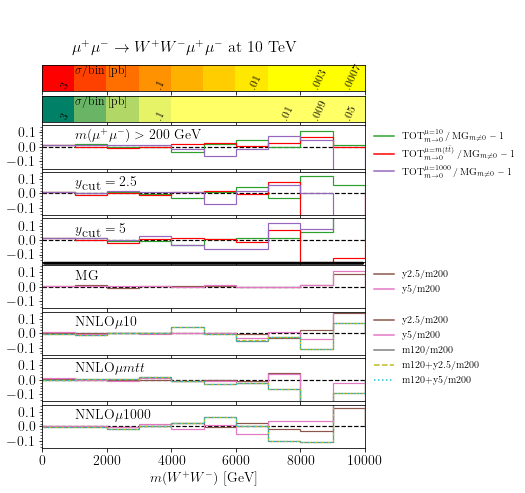

In [25]:
# Main plots for the technical paper
# mtt, compare m[mumu]>200 with ycuts
from matplotlib.colors import LogNorm
nrebin = 5 
import math
import itertools


def get_label_pos(histo, ypos=0.5):
    """find the label positions where the log10 of the xsection per bin increases by one unity
    always move towards the maximum"""
    imax = histo['y'].index(max(histo['y']))
    # from the left to the right
    lastlog = -20
    labels_left = []
    labels_left.append((histo['x'][imax], ypos, histo['y'][imax]))
    # from the left to the max
    for x, y in zip(histo['x'][:imax], histo['y'][:imax]):
        if y == 0: continue
        if lint(math.log10(y)) != lastlog:
            lastlog = lint(math.log10(y))
            print(y, lastlog)
            #labels_left.append((x, ypos, 10.**lastlog))
            labels_left.append((x, ypos, y))
    labels_right = []
    # from the right to the max
    lastlog=-20
    for x, y in reversed(list(zip(histo['x'][imax+1:], histo['y'][imax+1:]))):
        if y == 0: continue
        if lint(math.log10(y)) != lastlog:
            lastlog = lint(math.log10(y))
            print(y, lastlog)

            #labels_right.append((x, ypos,10.**lastlog))
            labels_right.append((x, ypos,y))
    print(labels_left,list(reversed(labels_right)))
    return labels_left + list(reversed(labels_right))

def lint(v):
    """returns the largest integer i for which i < v """
    if v > 0:
        return int(v)
    else:
        return int(v) - 1

def put_labels(ax, labels, color='w', fontsize=12, rotation=0):
    for x, y, v in labels:
        if int(v) != 0:
            ss = '%d' % v
        elif int(v*10) !=0:
            ss = '%.1f' % v
            ss = ss[1:]
        elif int(v*100) !=0:
            ss = '%.2f' % v
            ss = ss[1:]
        elif int(v*1000) !=0:
            ss = '%.3f' % v
            ss = ss[1:]
        elif int(v*10000) !=0:
            ss = '%.4f' % v
            ss = ss[1:]
        else:
            ss = 'AAAA'
        ax.annotate(ss, xy = (x*0.98,y), color = color, fontsize= fontsize, rotation=rotation)
    
            
        
        
    
for p, en in itertools.product(['tt', 'ww'], [3,10]):
#for p, en in itertools.product(['tt',], [3,10]):

    fname_mg_m200 = os.path.join(p, 'massive_madevent', 'histo_mtt_%dtev_biasmtt4.dat' % en)
    if en==10:
        fname_mg_m200_other = os.path.join(p, 'massive_madevent', 'histo_mtt_%dtev_biasmtt2.dat' % en)
    fname_nnlo1000_m200 = os.path.join(p, 'run_%dtev_comparemassive_mufix1000' % en, 'MADatNLO.HwU')
    fname_nnlo10_m200 = os.path.join(p, 'run_%dtev_comparemassive_mufix10' % en, 'MADatNLO.HwU')
    fname_nnlomtt_m200 = os.path.join(p, 'run_%dtev_comparemassive_mumtt' % en, 'MADatNLO.HwU')

    fname_mg_y25 = os.path.join(p, 'massive_madevent', 'histo_mtt_%dtev_ymax2.5_biasmtt4.dat' % en) 
    if en ==10:
        fname_mg_y25_other = os.path.join(p, 'massive_madevent', 'histo_mtt_%dtev_ymax2.5_biasmtt2.dat' % en)   
    fname_nnlo1000_y25 = os.path.join(p, 'run_%d000tev_comparemassive_ymax2.5_mufix1000' % en, 'MADatNLO.HwU')
    fname_nnlo10_y25 = os.path.join(p, 'run_%d000tev_comparemassive_ymax2.5_mufix10' % en, 'MADatNLO.HwU')
    fname_nnlomtt_y25 = os.path.join(p, 'run_%dtev_comparemassive_ycut2.5_mumtt' % en, 'MADatNLO.HwU')
    
    fname_mg_y5 = os.path.join(p, 'massive_madevent', 'histo_mtt_%dtev_ymax5_biasmtt4.dat' % en)
    if en ==10:
        fname_mg_y5_other = os.path.join(p, 'massive_madevent', 'histo_mtt_%dtev_ymax5_biasmtt2.dat' % en) 
    fname_nnlo1000_y5 = os.path.join(p, 'run_%d000tev_comparemassive_ymax5.0_mufix1000' % en, 'MADatNLO.HwU')
    fname_nnlo10_y5 = os.path.join(p, 'run_%d000tev_comparemassive_ymax5.0_mufix10' % en, 'MADatNLO.HwU')
    fname_nnlomtt_y5 = os.path.join(p, 'run_%dtev_comparemassive_ycut5.0_mumtt' % en, 'MADatNLO.HwU')

    fname_nnlo1000_m120 = os.path.join(p, 'run_%dtev_comparemassive_mcut120_mufix1000' % en, 'MADatNLO.HwU')
    fname_nnlo10_m120 = os.path.join(p, 'run_%dtev_comparemassive_mcut120_mufix10' % en, 'MADatNLO.HwU')
    fname_nnlomtt_m120 = os.path.join(p, 'run_%dtev_comparemassive_mcut120_mumtt' % en, 'MADatNLO.HwU')
    
    fname_nnlo1000_m120_y25 = os.path.join(p, 'run_%dtev_comparemassive_mcut120_ycut2.5_mufix1000' % en, 'MADatNLO.HwU')
    fname_nnlo10_m120_y25 = os.path.join(p, 'run_%dtev_comparemassive_mcut120_ycut2.5_mufix10' % en, 'MADatNLO.HwU')
    fname_nnlomtt_m120_y25 = os.path.join(p, 'run_%dtev_comparemassive_mcut120_ycut2.5_mumtt' % en, 'MADatNLO.HwU')
    
    fname_nnlo1000_m120_y5 = os.path.join(p, 'run_%dtev_comparemassive_mcut120_ycut5.0_mufix1000' % en, 'MADatNLO.HwU')
    fname_nnlo10_m120_y5 = os.path.join(p, 'run_%dtev_comparemassive_mcut120_ycut5.0_mufix10' % en, 'MADatNLO.HwU')
    fname_nnlomtt_m120_y5 = os.path.join(p, 'run_%dtev_comparemassive_mcut120_ycut5.0_mumtt' % en, 'MADatNLO.HwU')
    
    fname_lotot = os.path.join(p, 'run_%dtev_NLO_mumtt_msb_03permil' % en, 'MADatNLO.HwU')
            
    #histograms
    h_mg_m200 = get_histo_from_datfile(fname_mg_m200, 1e6, nrebin)
    h_mg_y25 = get_histo_from_datfile(fname_mg_y25, 1e6, nrebin)
    h_mg_y5 = get_histo_from_datfile(fname_mg_y5, 1e6, nrebin)
    
    if en == 10:
        h_mg_m200_other = get_histo_from_datfile(fname_mg_m200_other, 1e6, nrebin)
        h_mg_y25_other = get_histo_from_datfile(fname_mg_y25_other, 1e6, nrebin)
        h_mg_y5_other = get_histo_from_datfile(fname_mg_y5_other, 1e6, nrebin)
        h_mg_m200.replacefirstbins(h_mg_m200_other, 2001.)
        h_mg_y25.replacefirstbins(h_mg_y25_other, 2001.)
        h_mg_y5.replacefirstbins(h_mg_y5_other, 2001.)
    
    h_nnlo_1000_m200 = get_histo_from_file(fname_nnlo1000_m200, 'mtt', 'TOT', nrebin)
    h_nnlo_1000_y25 = get_histo_from_file(fname_nnlo1000_y25, 'mtt', 'TOT', nrebin)
    h_nnlo_1000_y5 = get_histo_from_file(fname_nnlo1000_y5, 'mtt', 'TOT', nrebin)
    
    h_nnlo_mtt_m200 = get_histo_from_file(fname_nnlomtt_m200, 'mtt', 'TOT', nrebin)
    h_nnlo_mtt_y25 = get_histo_from_file(fname_nnlomtt_y25, 'mtt', 'TOT', nrebin)
    h_nnlo_mtt_y5 = get_histo_from_file(fname_nnlomtt_y5, 'mtt', 'TOT', nrebin)

    h_nnlo_10_m200 = get_histo_from_file(fname_nnlo10_m200, 'mtt', 'TOT', nrebin)
    h_nnlo_10_y25 = get_histo_from_file(fname_nnlo10_y25, 'mtt', 'TOT', nrebin)
    h_nnlo_10_y5 = get_histo_from_file(fname_nnlo10_y5, 'mtt', 'TOT', nrebin)
    
    h_nnlo_1000_m120 = get_histo_from_file(fname_nnlo1000_m120, 'mtt', 'TOT', nrebin)
    h_nnlo_1000_m120_y25 = get_histo_from_file(fname_nnlo1000_m120_y25, 'mtt', 'TOT', nrebin)
    h_nnlo_1000_m120_y5 = get_histo_from_file(fname_nnlo1000_m120_y5, 'mtt', 'TOT', nrebin)

    h_nnlo_10_m120 = get_histo_from_file(fname_nnlo10_m120, 'mtt', 'TOT', nrebin)
    h_nnlo_10_m120_y25 = get_histo_from_file(fname_nnlo10_m120_y25, 'mtt', 'TOT', nrebin)
    h_nnlo_10_m120_y5 = get_histo_from_file(fname_nnlo10_m120_y5, 'mtt', 'TOT', nrebin)
    
    h_nnlo_mtt_m120 = get_histo_from_file(fname_nnlomtt_m120, 'mtt', 'TOT', nrebin)
    h_nnlo_mtt_m120_y25 = get_histo_from_file(fname_nnlomtt_m120_y25, 'mtt', 'TOT', nrebin)
    h_nnlo_mtt_m120_y5 = get_histo_from_file(fname_nnlomtt_m120_y5, 'mtt', 'TOT', nrebin)
    
    h_lotot = get_histo_from_file(fname_lotot, 'mtt', 'LO', nrebin)
    h_loaa = get_histo_from_file(fname_lotot, 'mtt', 'LOAA', nrebin)

    # now the figure
    fig, axes = plt.subplots(nrows = 9, ncols= 1, sharex = True, 
                                         gridspec_kw={'height_ratios': [1.2,1.2,2,2,2,2,2,2,2]})
    fig.set_size_inches(7*0.75,7)
    fig.suptitle("\n\n" + "    " + proc_string[p] + '$\\mu^+\\mu^-$' + ' at %d TeV' % en, fontsize=16, y=1.00) 

    for ax in axes:
        pos = ax.get_position()
        ax.set_position([pos.x0, pos.y0, pos.width*1.1, pos.height*1.1])
        ax.yaxis.set_minor_locator(AutoMinorLocator())
        ax.set_xlim(0,en*1000)
        
    # first inset, ratio with the m(200) cut wrt MG
    ax = axes[0]
    #ax.set_ylim(0.85,1.15)
    h_ratio = h_mg_m200/h_mg_m200
    if p == 'tt':
        unit = 1000. # convert to fb
        sunit = 'fb'
    elif p == 'ww':
        unit = 1. #stay in pb
        sunit = 'pb'
    
    heatmap=ax.pcolor([h_mg_m200['x']]*2, [[0]*h_mg_m200['nbins'], [1]*h_mg_m200['nbins']], [[y*unit for y in h_mg_m200['y']]]*2,
             norm=LogNorm(vmin=h_mg_m200.minv*unit*10, vmax=h_mg_m200.maxv*unit), cmap='autumn_r', shading='nearest')
    #contour=ax.contour([h_mg_m200['xlo']]*2, [[0]*h_mg_m200['nbins'], [1]*h_mg_m200['nbins']], [h_mg_m200['y']]*2,
    #                  levels=[10**i for i in range(-20,20,1)], colors='w')
    # put the labels of xsection levels
    put_labels(ax, get_label_pos(h_mg_m200*unit,-0.3), color='black', fontsize=12, rotation=65)
    ax.annotate('$\\sigma/\\textrm{bin}\\,\\, [\\textrm{%s}]$' % sunit, xy = (en*100,0.8), color = 'black', fontsize= 12)

    ax.get_yaxis().set_visible(False)
    
    ax = axes[1]
    heatmap=ax.pcolor([h_lotot['x']]*2, [[0]*h_lotot['nbins'], [1]*h_lotot['nbins']], [[y*unit for y in h_lotot['y']]]*2,
             norm=LogNorm(vmin=h_lotot.minv*unit*10, vmax=h_lotot.maxv*unit), cmap='summer_r', shading='nearest')
    #contour=ax.contour([h_mg_m200['xlo']]*2, [[0]*h_mg_m200['nbins'], [1]*h_mg_m200['nbins']], [h_mg_m200['y']]*2,
    #                  levels=[10**i for i in range(-20,20,1)], colors='w')
    # put the labels of xsection levels
    put_labels(ax, get_label_pos(h_lotot*unit,-0.3), color='black', fontsize=12, rotation=65)
    ax.annotate('$\\sigma/\\textrm{bin}\\,\\, [\\textrm{%s}]$' % sunit, xy = (en*100,0.8), color = 'black', fontsize= 12)

    ax.get_yaxis().set_visible(False)
    
    ax = axes[2]
    ax.set_ylim(-0.15,0.15)
    ax.text( 100*en, 0.05, '$m(\\mu^+\\mu^-) > 200$ GeV')

    ax.hist(x = h_ratio['x'], weights = [0]*h_ratio['nbins'], histtype= 'step', bins = h_ratio['nbins'], 
                       linewidth=lw, color=allcolors[1], linestyle = 'dashed', range=(0,en*1000))
    
    h_ratio = h_nnlo_10_m200/h_mg_m200 - 1 
    ax.hist(x = h_ratio['x'], weights = h_ratio['y'], histtype= 'step', bins = h_ratio['nbins'], 
                       linewidth=lw, color=allcolors[2], range=(0,en*1000), 
            label = '$\\textrm{TOT}_{m\\to 0}^{\\mu=10}\,/\,\\textrm{MG}_{m\\ne 0} -1$')
    h_ratio = h_nnlo_mtt_m200/h_mg_m200 - 1 
    ax.hist(x = h_ratio['x'], weights = h_ratio['y'], histtype= 'step', bins = h_ratio['nbins'], 
                       linewidth=lw, color=allcolors[3], range=(0,en*1000), 
            label = '$\\textrm{TOT}_{m\\to 0}^{\\mu=m(t\\bar t)}\,/\,\\textrm{MG}_{m\\ne 0} -1$')
    h_ratio = h_nnlo_1000_m200/h_mg_m200 - 1
    ax.hist(x = h_ratio['x'], weights = h_ratio['y'], histtype= 'step', bins = h_ratio['nbins'], 
                       linewidth=lw, color=allcolors[4], range=(0,en*1000), 
            label = '$\\textrm{TOT}_{m\\to 0}^{\\mu=1000}\,/\,\\textrm{MG}_{m\\ne 0} -1$')
    #h_ratio = h_nnlo_shat_m200/h_mg_m200
    #ax.hist(x = h_ratio['x'], weights = h_ratio['y'], histtype= 'step', bins = h_ratio['nbins'], 
    #                   linewidth=lw, color=allcolors[7], range=(0,en*1000), 
    #        label = 'NNLO$\\mu=\\hat s$/MG')
    
    #h_ratio = h_nnlo_mtt_m200/h_mg_m200
    #ax.hist(x = h_ratio['x'], weights = h_ratio['y'], histtype= 'step', bins = h_ratio['nbins'], 
    #                   linewidth=lw, color=allcolors[8], range=(0,en*1000), 
    #        label = 'NNLO$\\mu=m(tt)$/MG')

    update_legend(ax, ncol=1)

    # second inset, ratio with the y=2.5 cut wrt MG
    ax = axes[3]
    ax.set_ylim(-0.15,0.15)
    ax.text( 100*en, 0.05, '$y_{\\textrm{cut}}=2.5$')    
    h_ratio = h_mg_y25/h_mg_y25 - 1
    ax.hist(x = h_ratio['x'], weights = [0]*h_ratio['nbins'], histtype= 'step', bins = h_ratio['nbins'], 
                       linewidth=lw, color=allcolors[1], linestyle = 'dashed', range=(0,en*1000))
    h_ratio = h_nnlo_10_y25/h_mg_y25 - 1
    ax.hist(x = h_ratio['x'], weights = h_ratio['y'], histtype= 'step', bins = h_ratio['nbins'], 
                       linewidth=lw, color=allcolors[2], range=(0,en*1000), 
            label = 'NNLO$\\mu=10$/MG')
    h_ratio = h_nnlo_mtt_y25/h_mg_y25 - 1
    ax.hist(x = h_ratio['x'], weights = h_ratio['y'], histtype= 'step', bins = h_ratio['nbins'], 
                       linewidth=lw, color=allcolors[3], range=(0,en*1000), 
            label = 'NNLO$\\mu=mtt$/MG')
    h_ratio = h_nnlo_1000_y25/h_mg_y25 - 1
    ax.hist(x = h_ratio['x'], weights = h_ratio['y'], histtype= 'step', bins = h_ratio['nbins'], 
                       linewidth=lw, color=allcolors[4], range=(0,en*1000), 
            label = 'NNLO$\\mu=1000$/MG')
    
    # third inset, ratio with the y=5 cut wrt MG
    ax = axes[4]
    ax.set_ylim(-0.15,0.15)
    ax.text( 100*en, 0.05, '$y_{\\textrm{cut}}=5$')
    h_ratio = h_mg_y5/h_mg_y5
    ax.hist(x = h_ratio['x'], weights = [0]*h_ratio['nbins'], histtype= 'step', bins = h_ratio['nbins'], 
                       linewidth=lw, color=allcolors[1], linestyle = 'dashed', range=(0,en*1000))
    h_ratio = h_nnlo_10_y5/h_mg_y5 - 1
    ax.hist(x = h_ratio['x'], weights = h_ratio['y'], histtype= 'step', bins = h_ratio['nbins'], 
                       linewidth=lw, color=allcolors[2], range=(0,en*1000), 
            label = 'NNLO$\\mu=10$/MG')
    h_ratio = h_nnlo_mtt_y5/h_mg_y5 - 1
    ax.hist(x = h_ratio['x'], weights = h_ratio['y'], histtype= 'step', bins = h_ratio['nbins'], 
                       linewidth=lw, color=allcolors[3], range=(0,en*1000), 
            label = 'NNLO$\\mu=mtt$/MG')
    h_ratio = h_nnlo_1000_y5/h_mg_y5 - 1
    ax.hist(x = h_ratio['x'], weights = h_ratio['y'], histtype= 'step', bins = h_ratio['nbins'], 
                       linewidth=lw, color=allcolors[4], range=(0,en*1000), 
            label = 'NNLO$\\mu=1000$/MG')
    

    #ratios y=2.5 , y=5 /m200, madgraph
    ax = axes[5]
    # put a thick line above
    ax.annotate('', xy=(0.0, 1.04), xycoords='axes fraction', xytext=(1., 1.04), arrowprops=dict(arrowstyle="-", color='black', 
                                                                                             linewidth='3'))
    ax.set_ylim(-0.15,0.15)
    ax.text( 100*en, 0.05, 'MG')
    h_ratio = h_mg_m200/h_mg_m200 - 1
    ax.hist(x = h_ratio['x'], weights = [0]*h_ratio['nbins'], histtype= 'step', bins = h_ratio['nbins'], 
                       linewidth=lw, color=allcolors[1], linestyle = 'dashed', range=(0,en*1000))
    h_ratio = h_mg_y25/h_mg_m200 - 1
    ax.hist(x = h_ratio['x'], weights = h_ratio['y'], histtype= 'step', bins = h_ratio['nbins'], 
                       linewidth=lw, color=allcolors[5], range=(0,en*1000), 
            label = 'y2.5/m200')
    h_ratio = h_mg_y5/h_mg_m200 - 1
    ax.hist(x = h_ratio['x'], weights = h_ratio['y'], histtype= 'step', bins = h_ratio['nbins'], 
                       linewidth=lw, color=allcolors[6], range=(0,en*1000), 
            label = 'y5/m200')
    update_legend(ax, ncol=1)
    
    #ratios y=2.5 , y=5 /m200, NNLO mu10
    ax = axes[6]
    ax.set_ylim(-0.15,0.15)
    ax.text( 100*en, 0.05, 'NNLO$\\mu 10$')
    h_ratio = h_nnlo_10_m200/h_nnlo_10_m200 - 1
    ax.hist(x = h_ratio['x'], weights = [0]*h_ratio['nbins'], histtype= 'step', bins = h_ratio['nbins'], 
                       linewidth=lw, color=allcolors[1], linestyle = 'dashed', range=(0,en*1000))
    h_ratio = h_nnlo_10_y25/h_nnlo_10_m200 - 1
    ax.hist(x = h_ratio['x'], weights = h_ratio['y'], histtype= 'step', bins = h_ratio['nbins'], 
                       linewidth=lw, color=allcolors[5], range=(0,en*1000), 
            label = 'y2.5/m200')
    h_ratio = h_nnlo_10_y5/h_nnlo_10_m200 - 1
    ax.hist(x = h_ratio['x'], weights = h_ratio['y'], histtype= 'step', bins = h_ratio['nbins'], 
                       linewidth=lw, color=allcolors[6], range=(0,en*1000), 
            label = 'y5/m200')
    h_ratio = h_nnlo_10_m120/h_nnlo_10_m200 - 1
    ax.hist(x = h_ratio['x'], weights = h_ratio['y'], histtype= 'step', bins = h_ratio['nbins'], 
                       linewidth=lw, color=allcolors[7], linestyle='solid', range=(0,en*1000), 
            label = 'm120/m200')
    h_ratio = h_nnlo_10_m120_y25/h_nnlo_10_m200 - 1
    ax.hist(x = h_ratio['x'], weights = h_ratio['y'], histtype= 'step', bins = h_ratio['nbins'], 
                       linewidth=lw, color=allcolors[8], linestyle='dashed', range=(0,en*1000), 
            label = 'm120+y2.5/m200')
    h_ratio = h_nnlo_10_m120_y5/h_nnlo_10_m200 - 1
    ax.hist(x = h_ratio['x'], weights = h_ratio['y'], histtype= 'step', bins = h_ratio['nbins'], 
                       linewidth=lw, color=allcolors[9], linestyle='dotted', range=(0,en*1000), 
            label = 'm120+y5/m200')
    update_legend(ax, ncol=1)

    #ratios y=2.5 , y=5 /m200, NNLO mumtt
    ax = axes[7]
    ax.set_ylim(-0.15,0.15)
    ax.text( 100*en, 0.05, 'NNLO$\\mu mtt$')
    h_ratio = h_nnlo_mtt_m200/h_nnlo_mtt_m200 - 1
    ax.hist(x = h_ratio['x'], weights = [0]*h_ratio['nbins'], histtype= 'step', bins = h_ratio['nbins'], 
                       linewidth=lw, color=allcolors[1], linestyle = 'dashed', range=(0,en*1000))
    h_ratio = h_nnlo_mtt_y25/h_nnlo_mtt_m200 - 1
    ax.hist(x = h_ratio['x'], weights = h_ratio['y'], histtype= 'step', bins = h_ratio['nbins'], 
                       linewidth=lw, color=allcolors[5], range=(0,en*1000), 
            label = 'y2.5/m200')
    h_ratio = h_nnlo_mtt_y5/h_nnlo_mtt_m200 - 1
    ax.hist(x = h_ratio['x'], weights = h_ratio['y'], histtype= 'step', bins = h_ratio['nbins'], 
                       linewidth=lw, color=allcolors[6], range=(0,en*1000), 
            label = 'y5/m200')
    h_ratio = h_nnlo_mtt_m120/h_nnlo_mtt_m200 - 1
    ax.hist(x = h_ratio['x'], weights = h_ratio['y'], histtype= 'step', bins = h_ratio['nbins'], 
                       linewidth=lw, color=allcolors[7], linestyle='solid', range=(0,en*1000), 
            label = 'm120/m200')
    h_ratio = h_nnlo_mtt_m120_y25/h_nnlo_mtt_m200 - 1
    ax.hist(x = h_ratio['x'], weights = h_ratio['y'], histtype= 'step', bins = h_ratio['nbins'], 
                       linewidth=lw, color=allcolors[8], linestyle='dashed', range=(0,en*1000), 
            label = 'm120+y2.5/m200')
    h_ratio = h_nnlo_mtt_m120_y5/h_nnlo_mtt_m200 - 1
    ax.hist(x = h_ratio['x'], weights = h_ratio['y'], histtype= 'step', bins = h_ratio['nbins'], 
                       linewidth=lw, color=allcolors[9], linestyle='dotted', range=(0,en*1000), 
            label = 'm120+y5/m200')
    #update_legend(ax, ncol=1)
    
    #ratios y=2.5 , y=5 /m200, NNLO mu1000
    ax = axes[8]
    ax.set_ylim(-0.15,0.15)
    ax.text( 100*en, 0.05, 'NNLO$\\mu 1000$')
    h_ratio = h_nnlo_1000_m200/h_nnlo_1000_m200 - 1
    ax.hist(x = h_ratio['x'], weights = [0]*h_ratio['nbins'], histtype= 'step', bins = h_ratio['nbins'], 
                       linewidth=lw, color=allcolors[1], linestyle = 'dashed', range=(0,en*1000))
    h_ratio = h_nnlo_1000_y25/h_nnlo_1000_m200 - 1
    ax.hist(x = h_ratio['x'], weights = h_ratio['y'], histtype= 'step', bins = h_ratio['nbins'], 
                       linewidth=lw, color=allcolors[5], range=(0,en*1000), 
            label = 'y2.5/m200')
    h_ratio = h_nnlo_1000_y5/h_nnlo_1000_m200 - 1
    ax.hist(x = h_ratio['x'], weights = h_ratio['y'], histtype= 'step', bins = h_ratio['nbins'], 
                       linewidth=lw, color=allcolors[6], range=(0,en*1000), 
            label = 'y5/m200')
    h_ratio = h_nnlo_1000_m120/h_nnlo_1000_m200 - 1
    ax.hist(x = h_ratio['x'], weights = h_ratio['y'], histtype= 'step', bins = h_ratio['nbins'], 
                       linewidth=lw, color=allcolors[7], linestyle='solid', range=(0,en*1000), 
            label = 'm120/m200')
    h_ratio = h_nnlo_1000_m120_y25/h_nnlo_1000_m200 - 1
    ax.hist(x = h_ratio['x'], weights = h_ratio['y'], histtype= 'step', bins = h_ratio['nbins'], 
                       linewidth=lw, color=allcolors[8], linestyle='dashed', range=(0,en*1000), 
            label = 'm120+y2.5/m200')
    h_ratio = h_nnlo_1000_m120_y5/h_nnlo_1000_m200 - 1
    ax.hist(x = h_ratio['x'], weights = h_ratio['y'], histtype= 'step', bins = h_ratio['nbins'], 
                       linewidth=lw, color=allcolors[9], linestyle='dotted', range=(0,en*1000), 
            label = 'm120+y5/m200')
    
    ax.set_xlabel('$%s$ [GeV]' % xlabels[p]['mtt'])
    plt.savefig('check_massive2_%s_%dtev.pdf'  % (p,en), bbox_inches = 'tight')


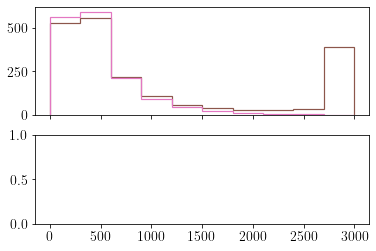

In [23]:
#for p, en in itertools.product(['tt', 'ww'], [3,10]):
for p, en in itertools.product(['ww',], [3]):

    fname_mg_m200 = os.path.join(p, 'massive_madevent', 'histo_mtt_%dtev_biasmtt4.dat' % en)
    if en==10:
        fname_mg_m200_other = os.path.join(p, 'massive_madevent', 'histo_mtt_%dtev_biasmtt2.dat' % en)
    fname_nnlo1000_m200 = os.path.join(p, 'run_%dtev_comparemassive_mufix1000' % en, 'MADatNLO.HwU')
    fname_nnlo10_m200 = os.path.join(p, 'run_%dtev_comparemassive_mufix10' % en, 'MADatNLO.HwU')
    fname_nnlomtt_m200 = os.path.join(p, 'run_%dtev_comparemassive_mumtt' % en, 'MADatNLO.HwU')

    fname_mg_y25 = os.path.join(p, 'massive_madevent', 'histo_mtt_%dtev_ymax2.5_biasmtt4.dat' % en) 
    if en ==10:
        fname_mg_y25_other = os.path.join(p, 'massive_madevent', 'histo_mtt_%dtev_ymax2.5_biasmtt2.dat' % en)   
    fname_nnlo1000_y25 = os.path.join(p, 'run_%d000tev_comparemassive_ymax2.5_mufix1000' % en, 'MADatNLO.HwU')
    fname_nnlo10_y25 = os.path.join(p, 'run_%d000tev_comparemassive_ymax2.5_mufix10' % en, 'MADatNLO.HwU')
    fname_nnlomtt_y25 = os.path.join(p, 'run_%dtev_comparemassive_ycut2.5_mumtt' % en, 'MADatNLO.HwU')
    
    fname_mg_y5 = os.path.join(p, 'massive_madevent', 'histo_mtt_%dtev_ymax5_biasmtt4.dat' % en)
    if en ==10:
        fname_mg_y5_other = os.path.join(p, 'massive_madevent', 'histo_mtt_%dtev_ymax5_biasmtt2.dat' % en) 
    fname_nnlo1000_y5 = os.path.join(p, 'run_%d000tev_comparemassive_ymax5.0_mufix1000' % en, 'MADatNLO.HwU')
    fname_nnlo10_y5 = os.path.join(p, 'run_%d000tev_comparemassive_ymax5.0_mufix10' % en, 'MADatNLO.HwU')
    fname_nnlomtt_y5 = os.path.join(p, 'run_%dtev_comparemassive_ycut5.0_mumtt' % en, 'MADatNLO.HwU')

    fname_nnlo1000_m120 = os.path.join(p, 'run_%dtev_comparemassive_mcut120_mufix1000' % en, 'MADatNLO.HwU')
    fname_nnlo10_m120 = os.path.join(p, 'run_%dtev_comparemassive_mcut120_mufix10' % en, 'MADatNLO.HwU')
    fname_nnlomtt_m120 = os.path.join(p, 'run_%dtev_comparemassive_mcut120_mumtt' % en, 'MADatNLO.HwU')
    
    fname_nnlo1000_m120_y25 = os.path.join(p, 'run_%dtev_comparemassive_mcut120_ycut2.5_mufix1000' % en, 'MADatNLO.HwU')
    fname_nnlo10_m120_y25 = os.path.join(p, 'run_%dtev_comparemassive_mcut120_ycut2.5_mufix10' % en, 'MADatNLO.HwU')
    fname_nnlomtt_m120_y25 = os.path.join(p, 'run_%dtev_comparemassive_mcut120_ycut2.5_mumtt' % en, 'MADatNLO.HwU')
    
    fname_nnlo1000_m120_y5 = os.path.join(p, 'run_%dtev_comparemassive_mcut120_ycut5.0_mufix1000' % en, 'MADatNLO.HwU')
    fname_nnlo10_m120_y5 = os.path.join(p, 'run_%dtev_comparemassive_mcut120_ycut5.0_mufix10' % en, 'MADatNLO.HwU')
    fname_nnlomtt_m120_y5 = os.path.join(p, 'run_%dtev_comparemassive_mcut120_ycut5.0_mumtt' % en, 'MADatNLO.HwU')
    
    fname_lotot = os.path.join(p, 'run_%dtev_NLO_mumtt_msb_03permil' % en, 'MADatNLO.HwU')
            
    #histograms
    h_mg_m200 = get_histo_from_datfile(fname_mg_m200, 1e6, nrebin)
    h_mg_y25 = get_histo_from_datfile(fname_mg_y25, 1e6, nrebin)
    h_mg_y5 = get_histo_from_datfile(fname_mg_y5, 1e6, nrebin)
    
    if en == 10:
        h_mg_m200_other = get_histo_from_datfile(fname_mg_m200_other, 1e6, nrebin)
        h_mg_y25_other = get_histo_from_datfile(fname_mg_y25_other, 1e6, nrebin)
        h_mg_y5_other = get_histo_from_datfile(fname_mg_y5_other, 1e6, nrebin)
        h_mg_m200.replacefirstbins(h_mg_m200_other, 2001.)
        h_mg_y25.replacefirstbins(h_mg_y25_other, 2001.)
        h_mg_y5.replacefirstbins(h_mg_y5_other, 2001.)
    
    h_nnlo_1000_m200 = get_histo_from_file(fname_nnlo1000_m200, 'mtt', 'TOT', nrebin)
    h_nnlo_1000_y25 = get_histo_from_file(fname_nnlo1000_y25, 'mtt', 'TOT', nrebin)
    h_nnlo_1000_y5 = get_histo_from_file(fname_nnlo1000_y5, 'mtt', 'TOT', nrebin)
    
    h_nnlo_mtt_m200 = get_histo_from_file(fname_nnlomtt_m200, 'mtt', 'TOT', nrebin)
    h_nnlo_mtt_y25 = get_histo_from_file(fname_nnlomtt_y25, 'mtt', 'TOT', nrebin)
    h_nnlo_mtt_y5 = get_histo_from_file(fname_nnlomtt_y5, 'mtt', 'TOT', nrebin)

    h_nnlo_10_m200 = get_histo_from_file(fname_nnlo10_m200, 'mtt', 'TOT', nrebin)
    h_nnlo_10_y25 = get_histo_from_file(fname_nnlo10_y25, 'mtt', 'TOT', nrebin)
    h_nnlo_10_y5 = get_histo_from_file(fname_nnlo10_y5, 'mtt', 'TOT', nrebin)
    
    h_nnlo_1000_m120 = get_histo_from_file(fname_nnlo1000_m120, 'mtt', 'TOT', nrebin)
    h_nnlo_1000_m120_y25 = get_histo_from_file(fname_nnlo1000_m120_y25, 'mtt', 'TOT', nrebin)
    h_nnlo_1000_m120_y5 = get_histo_from_file(fname_nnlo1000_m120_y5, 'mtt', 'TOT', nrebin)

    h_nnlo_10_m120 = get_histo_from_file(fname_nnlo10_m120, 'mtt', 'TOT', nrebin)
    h_nnlo_10_m120_y25 = get_histo_from_file(fname_nnlo10_m120_y25, 'mtt', 'TOT', nrebin)
    h_nnlo_10_m120_y5 = get_histo_from_file(fname_nnlo10_m120_y5, 'mtt', 'TOT', nrebin)
    
    h_nnlo_mtt_m120 = get_histo_from_file(fname_nnlomtt_m120, 'mtt', 'TOT', nrebin)
    h_nnlo_mtt_m120_y25 = get_histo_from_file(fname_nnlomtt_m120_y25, 'mtt', 'TOT', nrebin)
    h_nnlo_mtt_m120_y5 = get_histo_from_file(fname_nnlomtt_m120_y5, 'mtt', 'TOT', nrebin)
    
    h_lotot = get_histo_from_file(fname_lotot, 'mtt', 'LO', nrebin)
    h_loaa = get_histo_from_file(fname_lotot, 'mtt', 'LOAA', nrebin)
    
        # now the figure
    fig, axes = plt.subplots(nrows = 2, ncols= 1, sharex = True, 
                                         gridspec_kw={'height_ratios': [1.2,1.]})
    ax = axes[0]
    ax.hist(x = h_lotot['x'], weights = (h_lotot*1000)['y'], histtype= 'step', bins = h_lotot['nbins'], 
                       linewidth=lw, color=allcolors[5], range=(0,en*1000),)
    ax.hist(x = h_mg_m200['x'], weights = (h_mg_m200*1000)['y'], histtype= 'step', bins = h_mg_m200['nbins'], 
                       linewidth=lw, color=allcolors[6], range=(0,en*1000),)